In [2]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import log
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data = pd.read_csv('data/AAPL_daily.csv')
df = pd.DataFrame(data)
df.set_index("Date", inplace=True)

In [13]:
df[:5]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-02-01,4.865714,4.878214,4.720714,4.776786,4.071817,1010744000
2008-02-04,4.793214,4.853571,4.693571,4.701786,4.007886,899234000
2008-02-05,4.658214,4.785714,4.603571,4.620000,3.938171,1141042000
2008-02-06,4.672500,4.711429,4.348929,4.357143,3.714106,1573272400
2008-02-07,4.284643,4.456429,4.188214,4.330000,3.690970,2083331600


This dataset represents the financial data of every working day during 5 years.

For the LSTM network, we have to segments our dataset into batches of training and test sets. We will train our data on batches of three weeks, so 15 input data. The training set of each batch will consist of 14 input data for the train part, and the last input will be used for the test part.

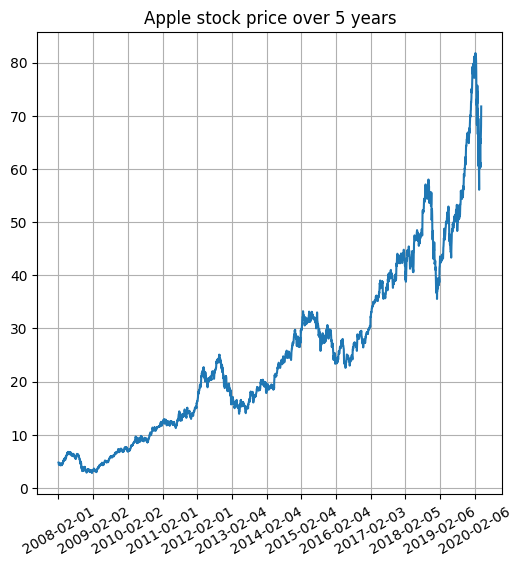

In [10]:
y = df['Close']
plt.figure(figsize=(6, 6))
plt.title('Apple stock price over 5 years')
plt.grid(True)
plt.xticks(np.arange(0, len(y), step=252), rotation=30)
plt.plot(y)
plt.show()

In [11]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High']
low_prices = df['Low']
mid_prices = (high_prices+low_prices) / 2
len(mid_prices)

3071

In [14]:
# Check the stationarity of the model with an ADF
result = adfuller(mid_prices.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.729867
p-value: 0.990415


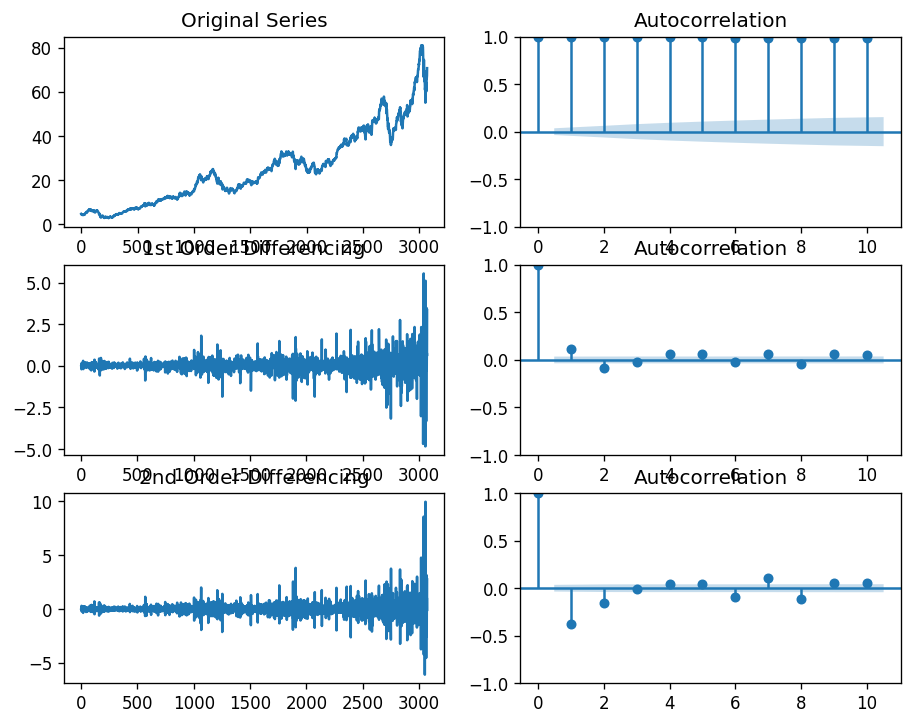

In [15]:
# As the p-value is above 0.05, we will differenciate the serie and check the autocorrelation plot
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
n_lags = 10

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(mid_prices.values); axes[0, 0].set_title('Original Series')
plot_acf(mid_prices.values, ax=axes[0, 1], lags=n_lags)

# 1st Differencing
axes[1, 0].plot(mid_prices.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mid_prices.diff().dropna(), ax=axes[1, 1], lags=n_lags)

# 2nd Differencing
axes[2, 0].plot(mid_prices.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mid_prices.diff().diff().dropna(), ax=axes[2, 1], lags=n_lags)

plt.show()

In [16]:
# Differentiate the signal once, to get the signal stationary
mid_prices_diff = mid_prices.diff().dropna()

In [17]:
# We will keep the last 15 days of the dataset as a training set
n_elems = len(mid_prices_diff)
batch_size = 60
test_size = batch_size * 8
train_data = mid_prices_diff[:-test_size]
test_data = mid_prices_diff[-test_size:]
print(train_data[:5])

Date
2008-02-04   -0.025893
2008-02-05   -0.078929
2008-02-06   -0.164463
2008-02-07   -0.207858
2008-02-08    0.093750
dtype: float64


In [18]:
# Scale the dataset
train_data = train_data.values
train_data = train_data.reshape(n_elems-test_size, 1)
test_data = test_data.values
test_data = test_data.reshape(test_size, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

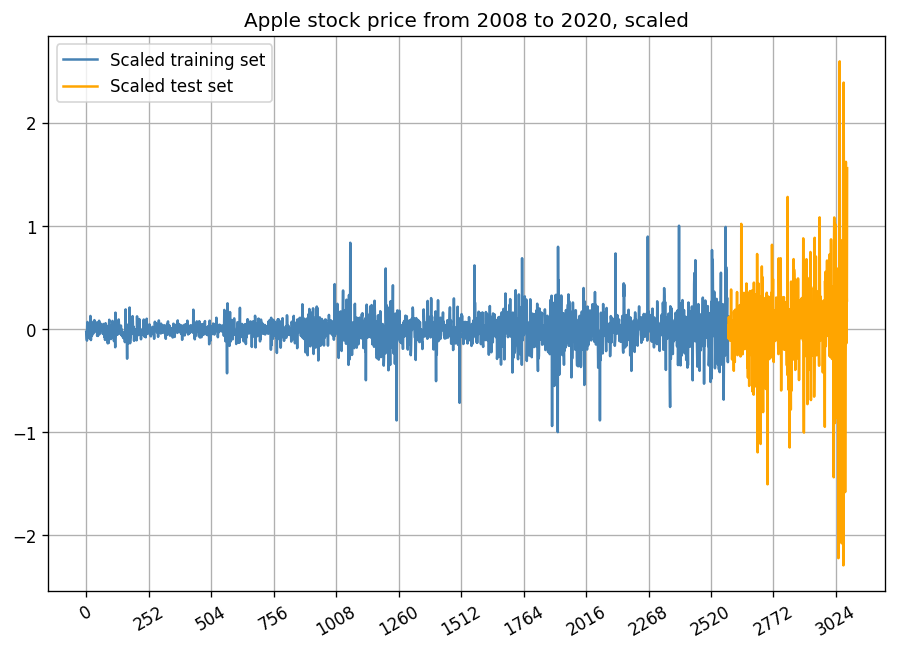

In [19]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(len(train_data)), train_data, color='steelblue')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, color='orange')

# you seemed to mess up the labels
plt.xticks(np.arange(0, len(mid_prices), step=252), rotation=30)
plt.legend(['Scaled training set', 'Scaled test set'])

plt.title('Apple stock price from 2008 to 2020, scaled')
plt.grid()
plt.show()

We must now prepare the batches of dataset for the LSTM. These batches will consist of three weeks of data, so 15 input data.

In [20]:
week_lenght = 1
train_X, train_y = [], []
for i in range(0, train_data.shape[0]-batch_size, week_lenght): 
        train_X.append(train_data[i:i+batch_size]) # each training sample is of length input hours
        train_y.append(train_data[i+batch_size][0]) # each y is just the next step after training sample

train_X = np.array(train_X) # format our new training set to keras format
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y) # make sure y is an array to work properly with keras
train_X.shape

(2530, 60, 1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# fit an LSTM network to training data
def fit_lstm(X, y, batch_size, nb_epochs, neurons):
    # X, y = train[:, 0:-1], train[:, -1]
    # X, y = train
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    # Adding first LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(rate=0.2))

    # Adding second LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding third LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding fourth LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding fifth LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epochs, batch_size=batch_size, verbose=0)
    model.summary()
    # for _ in range(nb_epoch):
    #     model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #     model.reset_states()
    return model

model = fit_lstm(train_X, train_y, batch_size=32, nb_epochs=100, neurons=100)

c:\Users\killi\Documents\Projects\Financial-Forecasting-with-Timeseries\env_name\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)         │        64,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,158,305 (4.42 MB)

 Trainable params: 386,101 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 772,204 (2.95 MB)

In [22]:
def forecast(model, batch_size, X_test, steps, n_preds):
    # print(X_test)
    X = X_test[:steps].copy().reshape(1,1,-1)
    X_list = X[0][0].tolist()
    preds = []
    
    for i in range(n_preds):
        pred = model.predict(X, batch_size=batch_size)
        X_list.append(X_test[steps+i][0])
        # X_list.append(pred[0][0])
        X_list.pop(0)
        preds.append(pred[0][0])
        # print(X_list[-batch_size:])
        X = np.array(X_list).reshape(1,1,-1) # replace first 11 values with 2nd through 12th
        # X[:,:,:-1] = pred # replace 12th value with prediction
        # print(X)
    return preds

steps = batch_size
n_preds = test_size - batch_size
preds = forecast(model, 1, test_data, steps, n_preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

In [23]:
# Prepare the data for the plot (unscale it and integrate it)
truth_unscaled = scaler.inverse_transform(test_data)
preds_unscaled = np.array(preds).reshape(-1, 1)
preds_unscaled = scaler.inverse_transform(preds_unscaled)

# Remove the train part of the truth values
train_size = len(mid_prices) - len(preds_unscaled)
start_val = mid_prices[train_size]
truth_unscaled = truth_unscaled[batch_size:]
truth = np.r_[start_val, truth_unscaled.reshape(-1)].cumsum()
# predictions = np.r_[start_val, preds_unscaled.reshape(-1)].cumsum()

# To build the predictions signal, take the lagged truth values, and add the predicitons of the model to generate the predicted values
predictions = np.vstack((truth.reshape(-1)[:-1], preds_unscaled.reshape(-1)))
predictions = predictions.sum(axis=0)
# predictions
# predictions = np.r_[130, preds_unscaled.reshape(-1)].cumsum()

C:\Users\killi\AppData\Local\Temp\ipykernel_25548\3058754785.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_val = mid_prices[train_size]


421
420


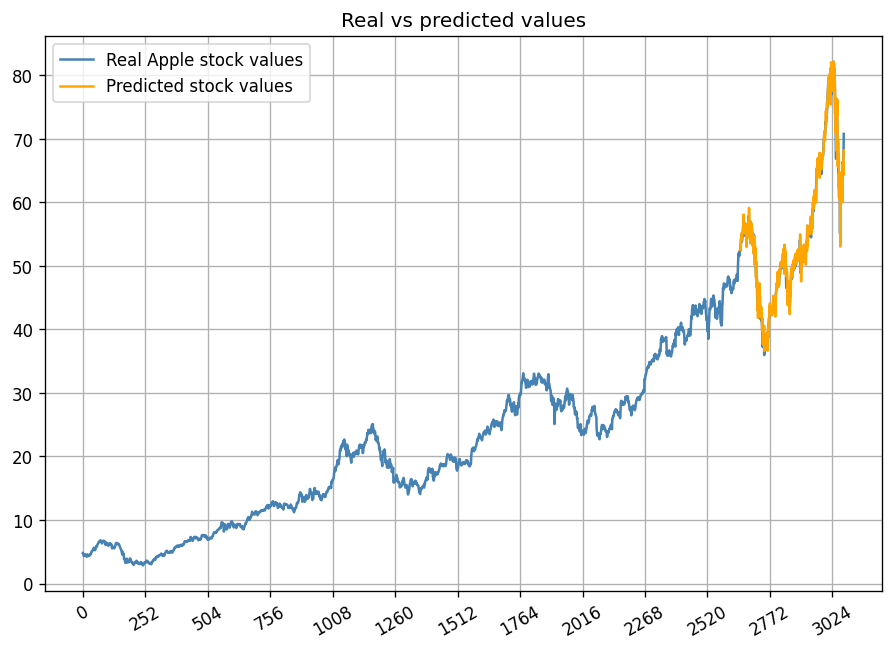

In [24]:
train_size = len(train_data)
print(len(truth))
print(len(predictions))
plt.figure(figsize=(9, 6))
plt.plot(np.arange(len(mid_prices)), mid_prices, color='steelblue')
# plt.plot(np.arange(train_size, train_size + len(truth)), truth, color='steelblue')
plt.plot(np.arange(len(mid_prices) - len(predictions), len(mid_prices)), predictions, color='orange')
plt.xticks(np.arange(0, len(mid_prices_diff), step=252), rotation=30)
# plt.plot(np.arange(len(mid_prices[-test_size:])), mid_prices[-test_size:], color='green')

# you seemed to mess up the labels
plt.title('Real vs predicted values')
plt.legend(['Real Apple stock values', 'Predicted stock values'])
plt.grid()
plt.show()

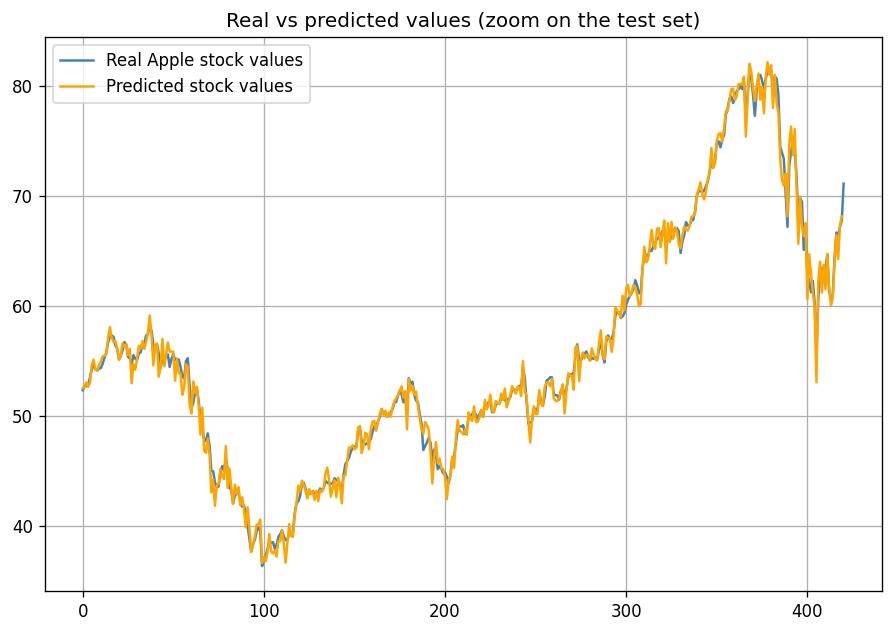

In [25]:
# Zoom on the test set
plt.figure(figsize=(9, 6))
plt.plot(np.arange(len(truth)), truth, color='steelblue')
# plt.plot(np.arange(train_size, train_size + len(truth)), truth, color='steelblue')
plt.plot(np.arange(len(predictions)), predictions, color='orange')
# plt.xticks(np.arange(0, len(mid_prices_diff), step=252), rotation=30)
# plt.plot(np.arange(len(mid_prices[-test_size:])), mid_prices[-test_size:], color='green')

# you seemed to mess up the labels
plt.title('Real vs predicted values (zoom on the test set)')
plt.legend(['Real Apple stock values', 'Predicted stock values'])
plt.grid()
plt.show()

In [26]:
# truth.tolist()
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(truth.tolist()[:-1],predictions.tolist()))
print(mean_absolute_error(truth.tolist()[:-1],predictions.tolist()))

0.7703522177702542
0.6432511616595937


# Display some nice plot for the presentation

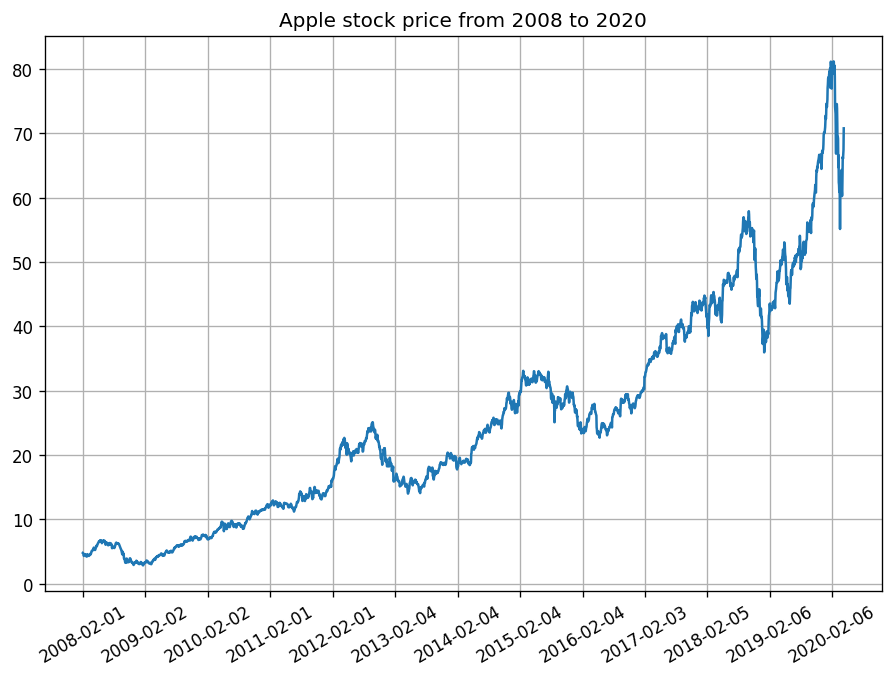

In [27]:
plt.figure(figsize=(9, 6))
plt.title('Apple stock price from 2008 to 2020')
plt.grid(True)
plt.xticks(np.arange(0, len(mid_prices), step=252), rotation=30)
plt.plot(mid_prices)
plt.show()

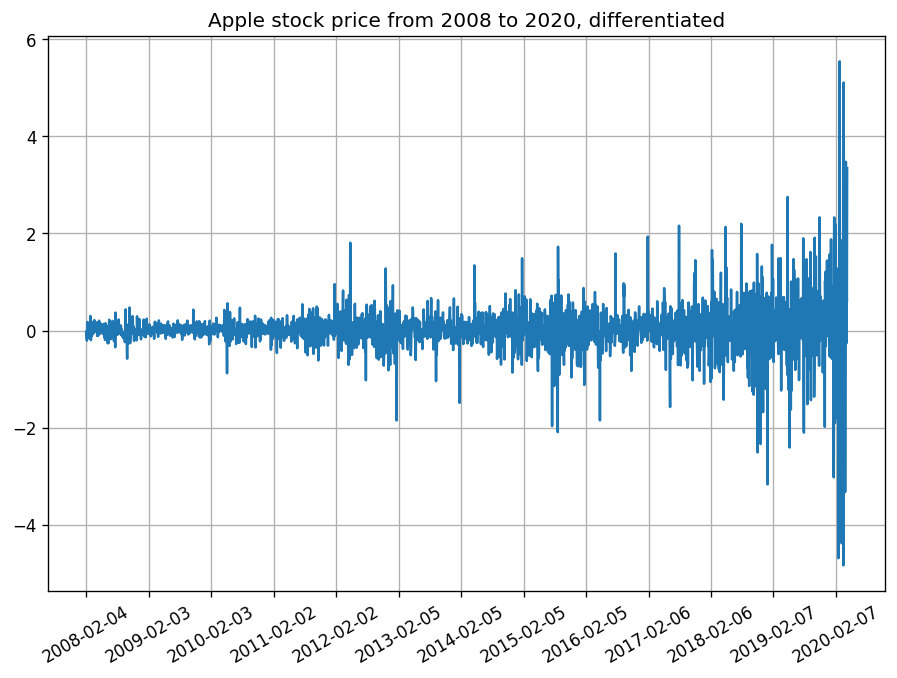

In [28]:
plt.figure(figsize=(9, 6))
plt.title('Apple stock price from 2008 to 2020, differentiated')
plt.grid(True)
plt.xticks(np.arange(0, len(mid_prices_diff), step=252), rotation=30)
plt.plot(mid_prices_diff)
plt.show()

# Apply the bot for LSTM

In [30]:
from tqdm import tqdm

def run_simulation(returns, prices, predictions, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
    curr_holding = False
    events_list = []
    # predictions = []
    init_amt = amt

    #go through dates
    i = 0
    for date, r in tqdm (returns.iloc[3000:].items(), total=len(returns.iloc[3000:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = prices[:date].to_numpy()
        curr_data = [x for x in curr_data]
        if type(order) == tuple:
            # print(i)
            pred = predictions[i]
            # try:
                # #fit model
                # model = ARIMA(curr_data, order=(n,1,m))
                # model_fit = model.fit()
                # #get forecast
                # pred = model_fit.forecast()
                # yhat = pred[0]
                # predictions.append(yhat)
            # except:
            #     pred = thresh - 1
            #     predictions.append(pred)
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
                ((type(order) == float and np.random.random() < order)
                 or (type(order) == tuple and pred > thresh)
                 or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
        i = i+1

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[3000:])
        plt.xticks(np.arange(0, len(prices[3000:]), step=10), rotation=30)

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(3000*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%('AAPL', thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt


In [31]:
preds_bot_size = len(mid_prices) - 3000
preds_bot = predictions[-preds_bot_size:]
preds_bot

array([72.97653968, 75.07688029, 75.66654254, 75.74499412, 74.97854734,
       76.19724263, 77.77875172, 77.77051921, 78.7594643 , 79.73264918,
       79.79999165, 78.75419268, 79.0880711 , 80.20190868, 80.22042389,
       80.15673092, 80.88618592, 75.43497826, 78.70623144, 82.05798682,
       81.40221784, 79.83040736, 78.66612621, 79.96079127, 81.1699057 ,
       78.78194201, 79.96346708, 77.5455151 , 80.85130597, 82.20925719,
       81.07455391, 81.93001555, 78.02775618, 81.04593782, 78.53563913,
       77.59748827, 73.31712681, 71.48951035, 70.95276179, 72.07029613,
       68.16570215, 74.7502467 , 76.34407572, 73.7399632 , 76.11147757,
       70.92508255, 65.66371939, 69.95825223, 67.29535382, 66.37158896,
       67.55832334, 60.62903185, 64.7196401 , 62.89406968, 61.23251273,
       59.92427533, 53.06222719, 62.14550528, 64.04668773, 61.23642668,
       63.76329476, 61.53283236, 64.76683131, 61.72747679, 60.0465485 ,
       60.74191343, 64.05873007, 66.48241216, 64.28242994, 67.40

100%|██████████| 70/70 [00:00<00:00, 9876.59it/s]


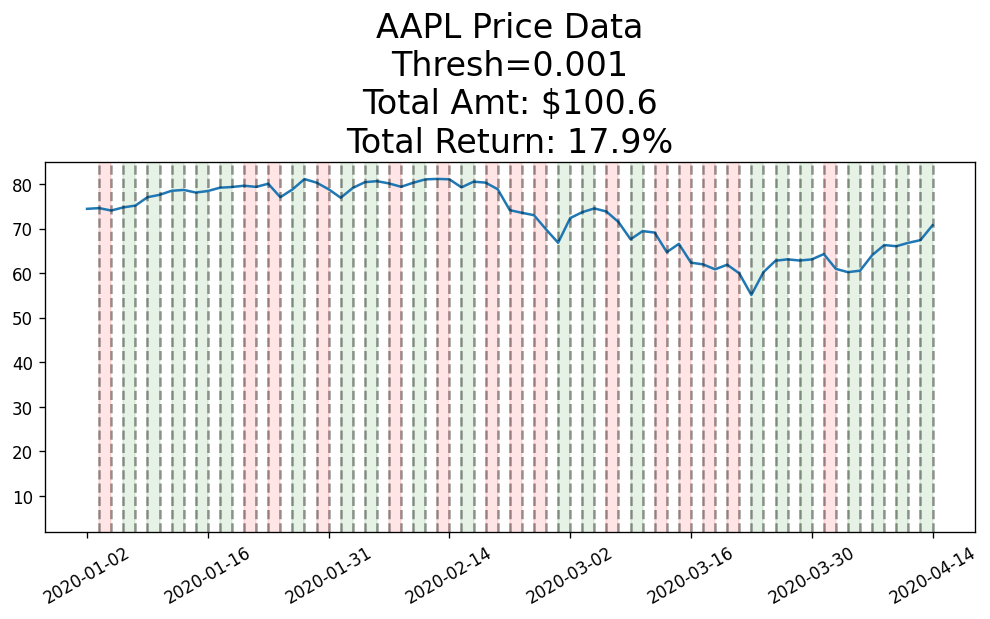

100.59652887571932

In [32]:
run_simulation(mid_prices_diff, mid_prices, preds_bot, 100, (1,1,1), 0.001, verbose=False, plot=True)